# Dependencies

### Section 1
*** Goal: *** To model the price and CO2 emissions by:
    * Entire Data Set
    * By Each State

### Section 2
*** Results Required: *** 
    * A Tree Diagram 
    * Feature Importance
    * P-Value significance chart
    * RMSE

### Section 3
*** Required Interpretation for each point of "Section 2" ***

In [118]:
'''
Libraries used
'''
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [119]:
'''
* Read dataset
* Remove the first no named column
* Adjust width for data view
* Drop 'Period Variable' as it is not a repetative feature.
'''
# df = pd.read_csv('data_690.csv')
df = pd.read_csv('linear_interpolated_data.csv')
# df = pd.read_csv('interpolated_data.csv') # cubic spline generated data
df = df.drop(['Unnamed: 0'], axis=1)
pd.set_option('display.max_columns', 70)
df = df.drop(['period'], axis=1)
df = df.drop(['for_wind__Power___193__V3__R2__Cp__in_watts'], axis=1)
df = df.drop(['for_solar__1367__kt__r__2__efficiency'], axis=1)
df.head()

,Year,Month,Net_generation_other_renewables_total__thousand_megawatthours,Average_retail_price_of_electricity_cents_per_KWH,Retail_sales_of_electricity_million_kilowatthours,Revenue_from_retail_sales_of_electricity_totalmillion_dollars,Revenue_from_retail_sales_of_electricity_residential_million_dollars,Total_consumption_coal_thousand_tons,Total_consumption_petroleum_liquid_thousand_barrels,Total_consumption__natural_gas_thousand_Mcf,unqid,kt_avg,T2M_avg,WS10M_avg,State,kt_max,T2M_max,WS10M_max,kt_min,T2M_min,WS10M_min,total_renewable_policy_count,Wind_policy_count,Solar_photovoltaic_policy_count,Electricity_Renew_No_Solar_Or_Wind_Unit_MWh,Charge_by_Department_dollars_per_MWh,Electricity_Consumed_Unit_MWh,Total_revenue_of_Retail_sales_electricity_in_million_dollars,Total_revenue_of_Retail_sales_Residential_in_million_dollars,Energy_produced_by_coal_thousand_tons_MWh,Energy_produced_by_petroleum_liquid_thousand_barrels_MWh,Energy_produced_by_natural_gas_thousand_MWh,for_wind_193_V3_R2_Cp_in_watts,for_solar_1367_kt_r_2_in_watts,Kg_CO2_emitted_from_Coal,Kg_CO2_emitted_from_Petrol,Kg_CO2_emitted_from_NaturalGas
0,2001,1,25.78400,6.01,250.60591,48.12840,15.07136,2317.575,4.739,228.521,2001_1_Wyoming,0.580634,7.877419,3.428387,Wyoming,0.79,20.49,7.33,0.21,0.05,0.78,38,3,2,25784.00,0.000060,250605.91,48128400.0,15071360.0,1.886738e+07,2788.620707,66.972894,400.732961,83.2503,7.706019e+05,1152.118210,4.134945e+04
1,2001,1,59.13588,7.53,4276.21487,727.44186,321.98899,4294.901,32.598,1093.509,2001_1_Illinois,0.496512,4.975000,3.038508,Illinois,0.79,16.24,5.95,0.07,0.00,0.57,93,13,16,59135.88,0.000075,4276214.87,727441860.0,321988990.0,3.496479e+07,19181.991516,320.475853,156.385263,27.7501,1.428070e+06,7925.036805,1.978636e+05
2,2001,1,5.11200,6.44,441.08794,62.82552,28.42055,986.528,0.485,1.770,2001_1_Montana,0.513096,6.872903,4.230335,Montana,0.76,18.65,10.94,0.17,0.01,0.69,48,13,14,5112.00,0.000064,441087.94,62825520.0,28420550.0,8.031324e+06,285.393763,0.518736,277.407711,67.3931,3.280240e+05,117.910389,3.202705e+02
3,2001,1,9.31800,6.71,1421.03141,214.82303,95.36042,1776.516,39.380,6023.636,2001_1_Colorado,0.586164,6.415760,3.230219,Colorado,0.81,20.49,9.25,0.06,0.01,0.88,134,18,47,9318.00,0.000067,1421031.41,214823030.0,95360420.0,1.446262e+07,23172.796672,1765.353449,575.465475,23.7858,5.906978e+05,9573.837333,1.089939e+06
4,2001,1,0.86562,5.87,3233.67091,365.03846,189.79038,3609.634,74.705,485.406,2001_1_Missouri,0.482445,3.415280,2.956570,Missouri,0.80,16.47,6.36,0.03,0.02,0.96,79,10,16,865.62,0.000059,3233670.91,365038460.0,189790380.0,2.938603e+07,43959.466109,142.258456,747.110700,11.8929,1.200216e+06,18161.846571,8.783120e+04


In [120]:
# converting column names to appropriate column names

'''
Inerest Variables: Charge_Department_dollars_per_MWh
'''

list_of_new_names = ['Year', 'Month','Electricity_Renew_No_Solar_Or_Wind_Unit_MWh',
                    'Charge_by_Department_dollars_per_MWh','Electricity_Consumed_Unit_MWh',
                     'Total_revenue_of_Retail_sales_electricity_in_million_dollars',
                    'Total_revenue_of_Retail_sales_Residential_in_million_dollars',
                     'Energy_produced_by_coal_thousand_tons_MWh',
                     'Energy_produced_by_petroleum_liquid_thousand_barrels_MWh',
                     'Energy_produced_by_natural_gas_thousand_MWh',
                     'unqid', 'kt_avg', 'T2M_avg', 'WS10M_avg', 'State', 'kt_max', 'T2M_max', 'WS10M_max',
       'kt_min', 'T2M_min', 'WS10M_min', 'for_wind_193_V3_R2_Cp_in_watts',
       'for_solar_1367_kt_r_2_in_watts', 'total_renewable_policy_count',
       'Wind_policy_count', 'Solar_photovoltaic_policy_count', 'Kg_CO2_emitted_from_Coal', 
                     'Kg_CO2_emitted_from_Petrol', 'Kg_CO2_emitted_from_NaturalGas' ]

new_df = df[list_of_new_names]
new_df['Total_CO2'] = new_df.Kg_CO2_emitted_from_Coal + new_df.Kg_CO2_emitted_from_NaturalGas + new_df.Kg_CO2_emitted_from_Petrol
new_df['Total_energy_produced_non_renewable_MWh'] = new_df.Energy_produced_by_coal_thousand_tons_MWh + new_df.Energy_produced_by_petroleum_liquid_thousand_barrels_MWh + new_df.Energy_produced_by_natural_gas_thousand_MWh
new_df['Total_energy_produced_all_MWh'] = new_df.Total_energy_produced_non_renewable_MWh + new_df.Electricity_Renew_No_Solar_Or_Wind_Unit_MWh
new_df['other_renewable_policy_count'] = new_df.total_renewable_policy_count - new_df.Wind_policy_count - new_df.Solar_photovoltaic_policy_count

# interest Variable
new_df['Total_revenue_in_million_dollars'] = new_df.Total_revenue_of_Retail_sales_electricity_in_million_dollars + new_df.Total_revenue_of_Retail_sales_Residential_in_million_dollars


# new_df['excess_electricity_produced'] = (new_df.Total_energy_produced_all_MWh - new_df.Electricity_Consumed_Unit_MWh)/1000
# new_df['relative_to_consumed_renewable_electricity_produced'] = (new_df.Total_energy_produced_non_renewable_MWh - new_df.Electricity_Consumed_Unit_MWh)/1000

new_df['relative_diff'] = (new_df.Total_energy_produced_all_MWh - 2* new_df.Total_energy_produced_non_renewable_MWh)*100/new_df.Total_energy_produced_all_MWh

new_df.to_csv('For_R_simulation.csv')

Total_CO2 = new_df.Total_CO2.tolist()
Year = new_df.Year.tolist()
Month = Year = new_df.Month.tolist()

new_df.tail(10)

,Year,Month,Electricity_Renew_No_Solar_Or_Wind_Unit_MWh,Charge_by_Department_dollars_per_MWh,Electricity_Consumed_Unit_MWh,Total_revenue_of_Retail_sales_electricity_in_million_dollars,Total_revenue_of_Retail_sales_Residential_in_million_dollars,Energy_produced_by_coal_thousand_tons_MWh,Energy_produced_by_petroleum_liquid_thousand_barrels_MWh,Energy_produced_by_natural_gas_thousand_MWh,unqid,kt_avg,T2M_avg,WS10M_avg,State,kt_max,T2M_max,WS10M_max,kt_min,T2M_min,WS10M_min,for_wind_193_V3_R2_Cp_in_watts,for_solar_1367_kt_r_2_in_watts,total_renewable_policy_count,Wind_policy_count,Solar_photovoltaic_policy_count,Kg_CO2_emitted_from_Coal,Kg_CO2_emitted_from_Petrol,Kg_CO2_emitted_from_NaturalGas,Total_CO2,Total_energy_produced_non_renewable_MWh,Total_energy_produced_all_MWh,other_renewable_policy_count,Total_revenue_in_million_dollars,relative_diff
9074,2017,7,428527.44,0.000136,789416.75,2.472275e+08,1.070949e+08,7.919394e+06,18142.412861,2687.644590,2017_7_NewMexico,0.613633,24.772183,3.301419,NewMexico,0.76,30.96,7.14,0.24,15.93,1.34,2031.821971,95.1432,63,16,25,323452.444186,7495.535046,1.659367e+06,1.990315e+06,7.940224e+06,8.368751e+06,22,3.543224e+08,-89.758868
9075,2017,7,217186.30,0.000160,3517225.42,1.103867e+09,5.633380e+08,4.701020e+05,26217.389104,7468.535231,2017_7_NewJersey,0.493167,23.014032,1.909516,NewJersey,0.70,27.88,4.89,0.11,18.60,0.81,448.772580,43.6073,56,12,19,19200.415911,10831.710222,4.611117e+06,4.641149e+06,5.037880e+05,7.209743e+05,25,1.667205e+09,-39.751997
9076,2017,7,334211.81,0.000124,4736399.99,1.086876e+09,5.878493e+08,5.708819e+06,33407.546609,11105.448740,2017_7_Virginia,0.538411,25.418629,1.863844,Virginia,0.73,31.13,5.82,0.05,17.53,0.72,315.187327,19.8215,59,16,21,233165.767680,13802.322674,6.856568e+06,7.103537e+06,5.753332e+06,6.087544e+06,22,1.674725e+09,-89.019815
9077,2017,7,647588.12,0.000125,2048420.78,5.658852e+08,2.550992e+08,1.324323e+07,22898.779430,3693.716251,2017_7_Colorado,0.588409,20.936371,2.785703,Colorado,0.79,31.80,7.62,0.13,11.83,1.03,922.747615,51.5359,134,18,47,540894.452787,9460.627152,2.280522e+06,2.830877e+06,1.326983e+07,1.391741e+07,69,8.209845e+08,-90.693844
9078,2017,7,195610.42,0.000190,408436.39,1.564184e+08,7.752856e+07,8.973824e+04,12390.012251,856.790636,2017_7_NewHampshire,0.498833,18.990000,1.594839,NewHampshire,0.71,23.45,2.21,0.09,13.55,1.06,1005.747248,35.6787,62,9,10,3665.186329,5118.931630,5.289875e+05,5.377716e+05,1.029850e+05,2.985955e+05,43,2.339469e+08,31.020355
9079,2017,7,742158.46,0.000116,2001745.09,4.175248e+08,2.329770e+08,1.447934e+06,1881.245073,6731.660192,2017_7_Nevada,0.653420,25.279474,2.864241,Nevada,0.80,33.46,5.76,0.21,19.24,1.30,1855.245189,83.2503,40,14,15,59138.079014,777.236109,4.156166e+06,4.216081e+06,1.456547e+06,2.198705e+06,11,6.505018e+08,-32.491317
9080,2017,7,257110.05,0.000121,222958.51,1.191853e+08,2.709251e+07,1.990912e+07,1964.803659,99.937528,2017_7_Wyoming,0.632328,21.365829,2.994988,Wyoming,0.79,28.13,5.86,0.11,13.85,1.12,1186.384121,43.6073,38,3,2,813149.667085,811.758325,6.170201e+04,8.756634e+05,1.991118e+07,2.016829e+07,33,1.462778e+08,-97.450354
9081,2017,7,224854.69,0.000120,1071319.51,3.127342e+08,1.285858e+08,1.127295e+07,2082.295662,555.972818,2017_7_Nebraska,0.610364,26.071248,3.879397,Nebraska,0.75,32.51,7.64,0.09,20.71,1.42,2417.888615,35.6787,44,9,9,460421.950254,860.300128,3.432608e+05,8.045431e+05,1.127559e+07,1.150044e+07,26,4.413200e+08,-96.089634
9082,2017,7,5008539.70,0.000189,9505135.84,4.266874e+09,1.791971e+09,0.000000e+00,2199.787664,19654.914482,2017_7_California,0.702227,26.187177,3.171664,California,0.80,40.19,12.11,0.21,12.73,1.25,1649.306218,83.2503,255,28,79,0.000000,908.841931,1.213506e+07,1.213597e+07,2.185470e+04,5.030394e+06,148,6.058845e+09,99.131094
9083,2017,7,303596.60,0.000125,3429518.28,8.787699e+08,4.295821e+08,1.513162e+07,2317.279667,12570.976417,2017_7_Alabama,0.558278,27.427392,1.380161,Alabama,0.71,30.42,3.20,0.08,24.62,0.43,67.139271,31.7144,37,5,7,618021.969883,957.383

# just for our understanding!

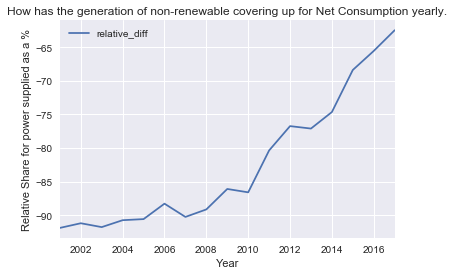

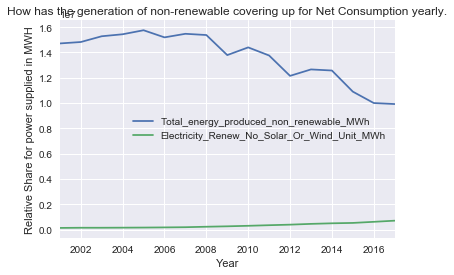

In [123]:
'''
* How has the Renewable sources grown over time?
'''

# Plot the relative increase in the solar power as a percentage of non- renewable power
summary_df = new_df.groupby(['Year']).mean()

# removed 2017 for consitancy reasons
# summary_df = summary_df[summary_df.Month > 5]

columns_of_interest = ['relative_diff']
summary_df[columns_of_interest].plot()

summary_df.head()

plt.title('How has the generation of non-renewable covering up for Net Consumption yearly.')
plt.xlabel('Year')
plt.ylabel('Relative Share for power supplied as a %')

# see the summary over years
# summary_df

columns_of_interest = ['Total_energy_produced_non_renewable_MWh', 'Electricity_Renew_No_Solar_Or_Wind_Unit_MWh']

# need to lookup for the units in this chart!
summary_df[columns_of_interest].plot()
plt.title('How has the generation of non-renewable covering up for Net Consumption yearly.')
plt.xlabel('Year')
plt.ylabel('Relative Share for power supplied in MWH')

# Curating data for ML

In [99]:
# step 1: conversion of data to numeric form

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Label encoded to be fed into Model
col_names = ['State', 'unqid']
for i in col_names:
    le.fit(new_df[[i]])
    new_df[[i]] = le.transform(new_df[[i]])   
    
# Check if there is any null?
# df.isnull().sum()
print("total count of null's or unwanted cells in the data: ", new_df.isnull().sum().sum())

total count of null's or unwanted cells in the data:  0


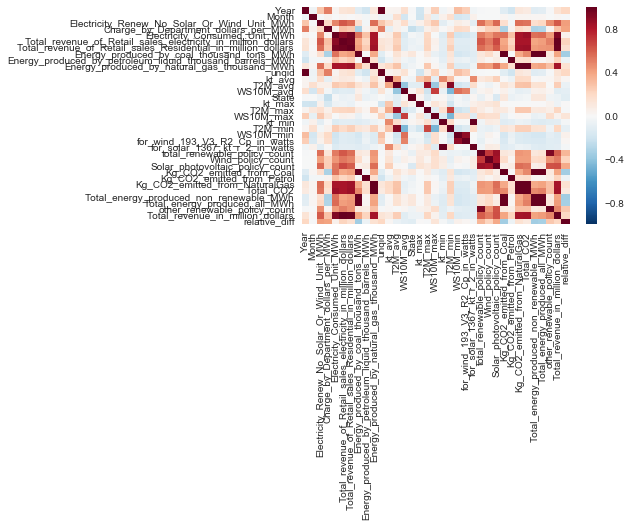

In [100]:
corr = new_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

[]

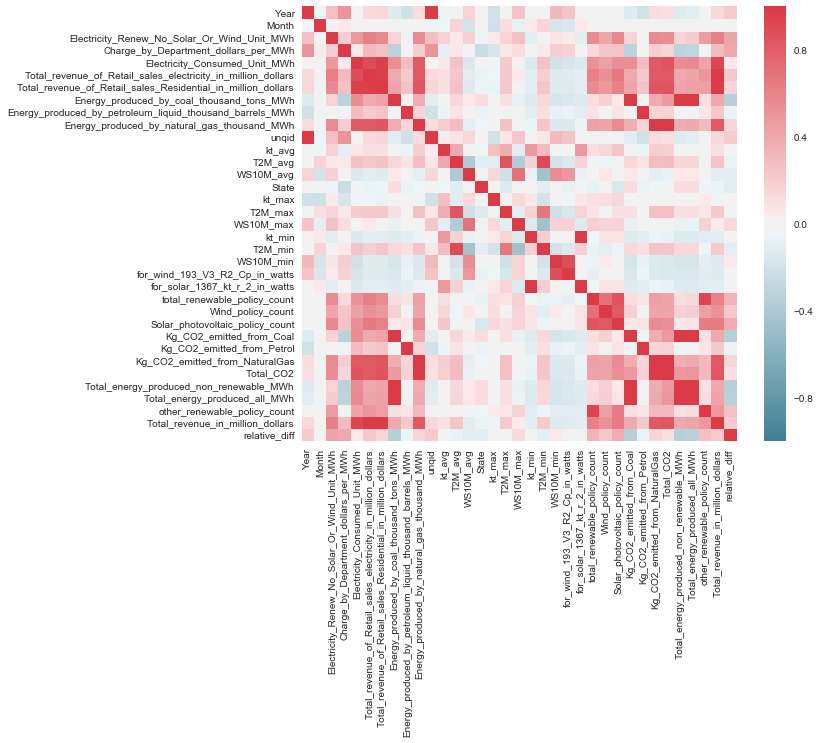

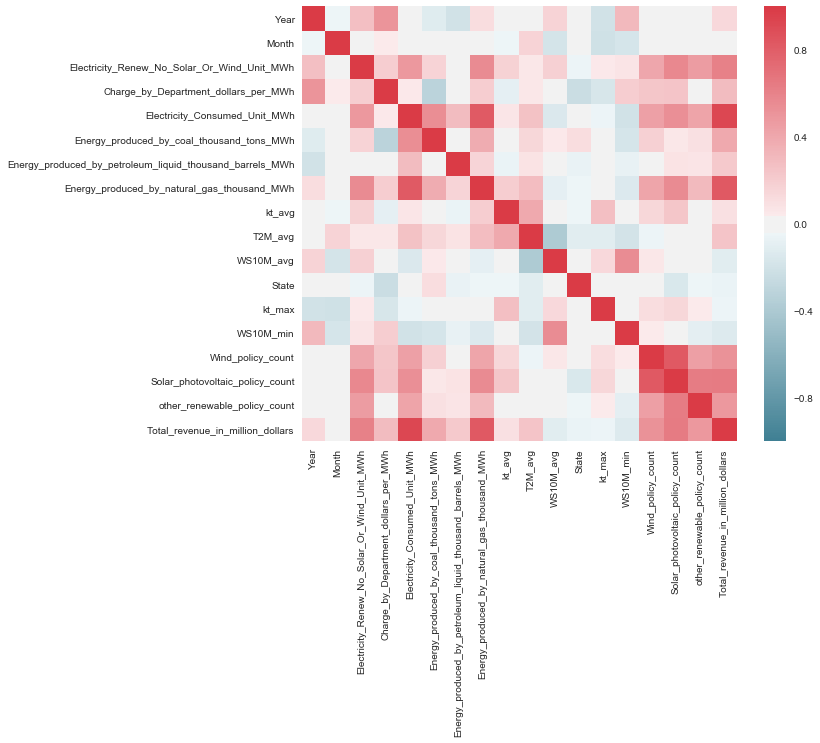

In [101]:
f, ax = plt.subplots(figsize=(10, 8))
corr = new_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.plot()

# correlated list
corr_list = ['unqid', 
             'Total_revenue_of_Retail_sales_Residential_in_million_dollars', 
             'Total_revenue_of_Retail_sales_electricity_in_million_dollars',
             'T2M_max', 'T2M_min', 'kt_min', 'Kg_CO2_emitted_from_Coal',  
             'Kg_CO2_emitted_from_Petrol', 'Kg_CO2_emitted_from_NaturalGas',
            'Total_energy_produced_non_renewable_MWh',
            'Total_energy_produced_all_MWh', 'Total_CO2',
            'total_renewable_policy_count',
            'for_solar_1367_kt_r_2_in_watts',
            'for_wind_193_V3_R2_Cp_in_watts', 'relative_diff', 'WS10M_max'
            ]

new_df = new_df.drop(corr_list, axis = 1)

# Plot again to see if still correlated columns exists
f, ax = plt.subplots(figsize=(10, 8))
corr = new_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.plot()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

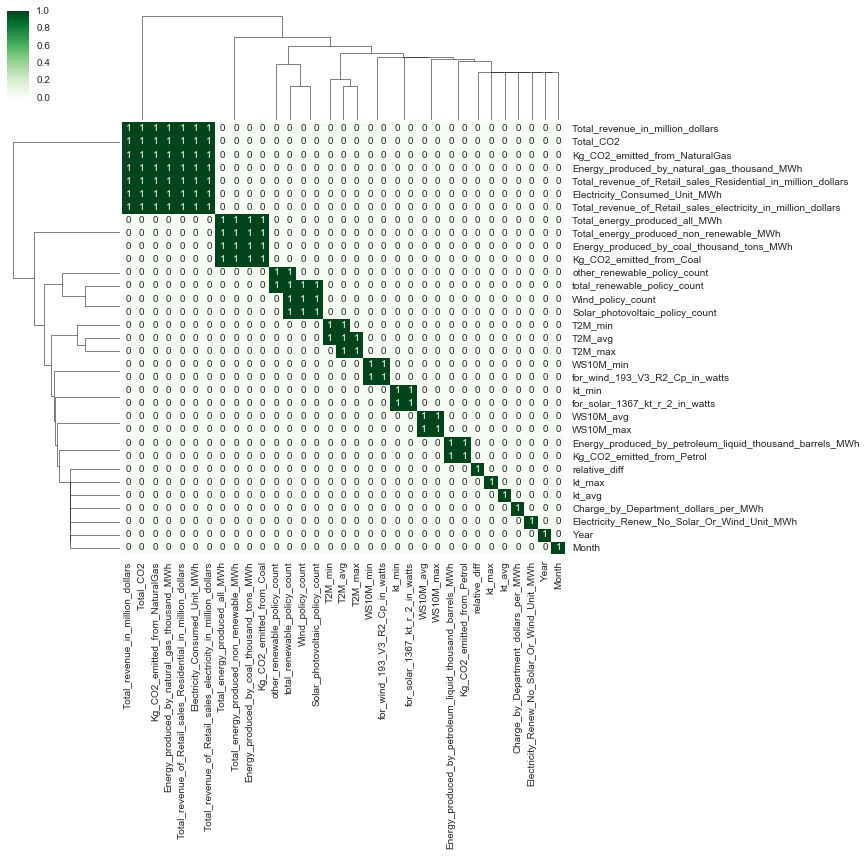

In [153]:
corr = new_df.corr().mul(1.5).astype(int)
g = sns.clustermap(data=corr, annot=True, fmt='d', cmap='Greens')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

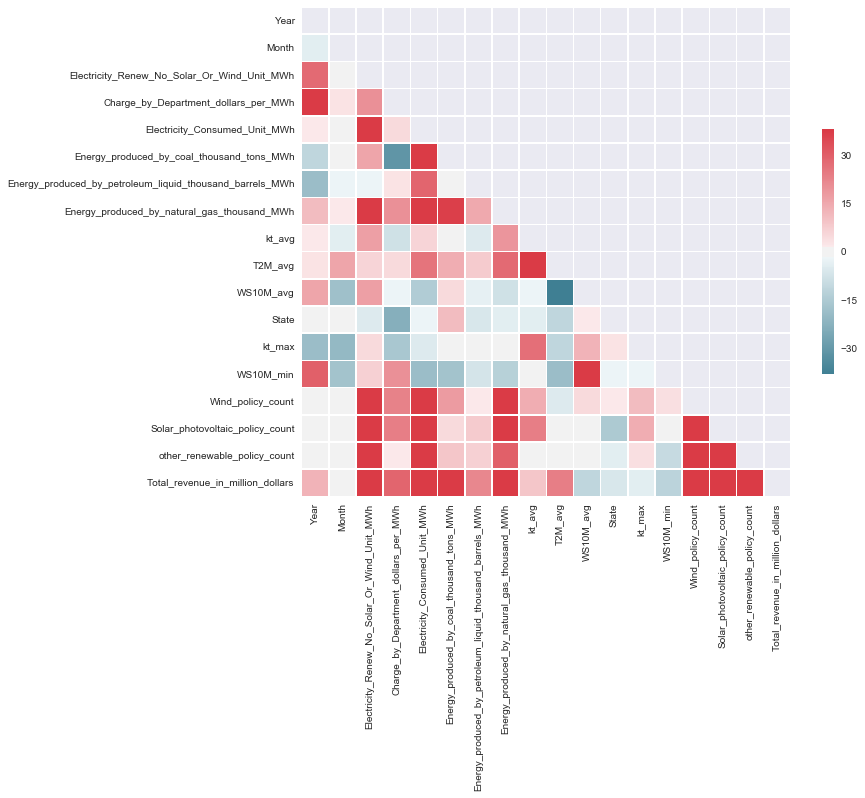

In [103]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Train test Split

In [104]:
# Step 3: separating the Y from actual data

y = new_df.Total_revenue_in_million_dollars
x = new_df.drop(['Total_revenue_in_million_dollars'], axis=1)


# y = new_df.Total_revenue_of_Retail_sales_electricity_in_million_dollars
# x = new_df.drop(['Total_revenue_of_Retail_sales_electricity_in_million_dollars'], axis=1)

# Just to make sure that I didn't mess it up
print(y.shape, x.shape, new_df.shape) 

# Preparing Train Test Split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
X_train.shape, y_train.shape

(9084,) (9084, 17) (9084, 18)


((6813, 17), (6813,))

In [105]:
# A quick look a final dataset for modeling
X_train.sample(5)

,Year,Month,Electricity_Renew_No_Solar_Or_Wind_Unit_MWh,Charge_by_Department_dollars_per_MWh,Electricity_Consumed_Unit_MWh,Energy_produced_by_coal_thousand_tons_MWh,Energy_produced_by_petroleum_liquid_thousand_barrels_MWh,Energy_produced_by_natural_gas_thousand_MWh,kt_avg,T2M_avg,WS10M_avg,State,kt_max,WS10M_min,Wind_policy_count,Solar_photovoltaic_policy_count,other_renewable_policy_count
1559,2003,8,73514.38,0.000090,4987108.25,4.080652e+07,209487.260192,2861.999310,0.557500,24.430363,2.249738,10,0.75,0.68,13,16,64
4182,2008,6,246495.11,0.000096,3983011.31,1.021948e+07,210585.290629,3557.744755,0.593564,23.565056,1.907583,41,0.73,0.73,16,21,22
8995,2017,6,234099.65,0.000131,2728421.39,5.867292e+06,8244.054885,3377.600416,0.531762,25.392852,2.328778,36,0.72,0.84,8,14,47
2139,2004,9,155569.10,0.000083,1713090.97,1.433741e+07,5219.157565,437.191424,0.500877,15.149654,3.624802,20,0.77,1.10,18,29,142
8773,2017,1,289431.79,0.000113,2390449.68,1.259166e+07,7515.565239,2772.270034,0.516894,5.860119,3.932593,2,0.78,1.25,25,33,18


# Linear Regression

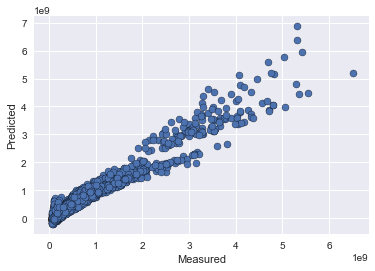

Value of sum of least square: 1.13900310211e+40


In [124]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X_train, y_train, cv=10)

fig, ax = plt.subplots()
ax.scatter(y_test, lr.predict(X_test), edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

print('Value of sum of least square:', np.square(sum((y_test - lr.predict(X_test))**2)))

In [107]:
print(lr.score(X_train, y_train))

0.94713593585


In [108]:
import statsmodels.api as sm

# Model Training
model = sm.OLS(y_train, X_train).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Total_revenue_in_million_dollars   R-squared:                       0.971
Model:                                          OLS   Adj. R-squared:                  0.971
Method:                               Least Squares   F-statistic:                 1.349e+04
Date:                              Fri, 08 Dec 2017   Prob (F-statistic):               0.00
Time:                                      01:08:03   Log-Likelihood:            -1.4040e+05
No. Observations:                              6813   AIC:                         2.808e+05
Df Residuals:                                  6796   BIC:                         2.809e+05
Df Model:                                        17                                         
Covariance Type:                          nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Year                                                     -5.209e+05   2.27e+04    -22.925      0.000   -5.65e+05   -4.76e+05
Month                                                     3.455e+06   8.08e+05      4.275      0.000    1.87e+06    5.04e+06
Electricity_Renew_No_Solar_Or_Wind_Unit_MWh                160.5808      6.726     23.875      0.000     147.396     173.766
Charge_by_Department_dollars_per_MWh                      6.699e+12   1.11e+11     60.545      0.000    6.48e+12    6.92e+12
Electricity_Consumed_Unit_MWh                              302.0292      2.739    110.263      0.000     296.660     307.399
Energy_produced_by_coal_thousand_tons_MWh                    1.0990      0.305      3.605      0.000       0.501       1.697
Energy_produced_by_petroleum_liquid_thousand_barrels_MWh   -82.7547     10.883     -7.604      0.000    -104.089     -61.420
Energy_produced_by_natural_gas_thousand_MWh               3359.0849    819.594      4.098      0.000    1752.424    4965.745
kt_avg                                                    2.446e+08    4.6e+07      5.317      0.000    1.54e+08    3.35e+08
T2M_avg                                                  -3.377e+05   4.62e+05     -0.730      0.465   -1.24e+06    5.68e+05
WS10M_avg                                                 -6.21e+06   3.96e+06     -1.568      0.117    -1.4e+07    1.55e+06
State                                                     2.714e+06   2.19e+05     12.379      0.000    2.28e+06    3.14e+06
kt_max                                                    1.686e+08   4.73e+07      3.567      0.000    7.59e+07    2.61e+08
WS10M_min                                                -1.557e+07    9.2e+06     -1.693      0.091   -3.36e+07    2.46e+06
Wind_policy_count                                        -1.116e+07    8.3e+05    -13.440      0.000   -1.28e+07   -9.53e+06
Solar_photovoltaic_policy_count                           9.529e+06   5.21e+05     18.291      0.000    8.51e+06    1.06e+07
other_renewable_policy_count                              1.081e+06   1.25e+05      8.675      0.000    8.37e+05    1.33e+06
==============================================================================
Omnibus:                     1361.617   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11675.786
Skew:                           0.714   Prob(JB):                         0.00
Kurtosis:                       9.252   Cond. No.                     8.11e+11
==================================

The sum of least squares: 5.79429994036e+18


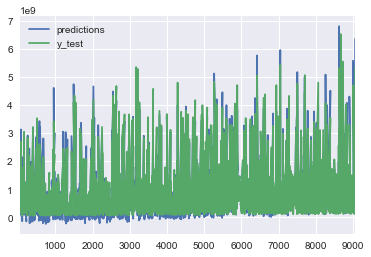

In [109]:
predictions = model.predict(X_test) # make the predictions by the model

# Least Squares
print('The sum of least squares:',np.square(sum(y_test - predictions)))

Predictions_df = pd.DataFrame(
    {
    'date': (X_test["Year"].map(str) + '-' + X_test["Month"].map(str)),  
    'y_test':y_test,
    'predictions': predictions
})

Predictions_df.sort_values(['date'], ascending=[1]).plot()

In [110]:
print('Slope:', lr.intercept_)
print('\nCoefficient:', lr.coef_)


imp_df = pd.DataFrame(lr.coef_, X_train.columns)
imp_df

Slope: 23764511986.2

Coefficient: [ -1.24028566e+07   2.90011166e+06   1.85356977e+02   7.67294769e+12
   3.08532384e+02   8.00351589e-01  -1.29745930e+02   2.67490543e+03
   3.59147560e+08  -5.27714569e+05  -9.42801826e+05   3.06599579e+06
   5.60782082e+07   5.65654478e+06  -1.17160112e+07   8.16603258e+06
   1.17246872e+06]


,0
Year,-1.240286e+07
Month,2.900112e+06
Electricity_Renew_No_Solar_Or_Wind_Unit_MWh,1.853570e+02
Charge_by_Department_dollars_per_MWh,7.672948e+12
Electricity_Consumed_Unit_MWh,3.085324e+02
Energy_produced_by_coal_thousand_tons_MWh,8.003516e-01
Energy_produced_by_petroleum_liquid_thousand_barrels_MWh,-1.297459e+02
Energy_produced_by_natural_gas_thousand_MWh,2.674905e+03
kt_avg,3.591476e+08
T2M_avg,-5.277146e+05


# Random Forest

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=1,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

print(regr.feature_importances_)

[  1.31621131e-03   1.31961928e-03   2.77941673e-02   5.44626893e-02
   3.23150075e-01   2.17918740e-03   1.70648431e-03   5.57111324e-01
   8.88793253e-04   1.44161260e-02   9.92814993e-04   3.93066235e-04
   6.29105083e-04   4.94926002e-04   6.74884504e-04   2.37778905e-03
   1.00927364e-02]


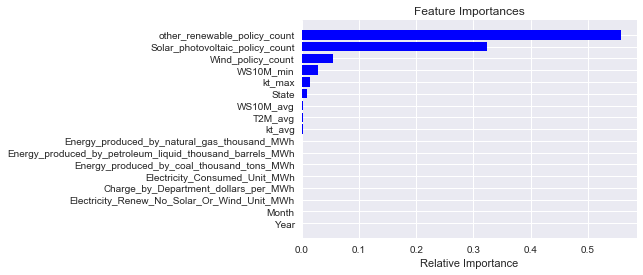

In [112]:
features = X_train.columns
importances = regr.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

In [113]:
# import statsmodels.api as sm

In [114]:
# ! conda install statsmodels --yes

# CO2 Emissions understanding and Projections?

In [115]:
difference = []
for i in range(len(Total_CO2)-1):
    diff = Total_CO2[i+1] - Total_CO2[i]
    difference.append(diff)

# add 0 to the end to balance out the length difference
difference.append(0)

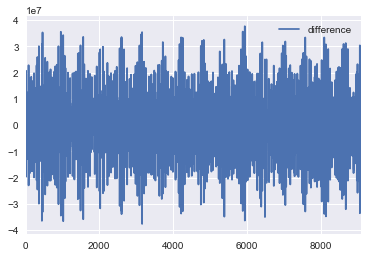

In [116]:
CO2_changes = pd.DataFrame(
    {
    'difference':difference
})


CO2_changes['Year_Month'] = (new_df["Year"].map(str) + '-' + new_df["Month"].map(str))
CO2_changes.plot()

# step regression:

In [93]:
import statsmodels.formula.api as smf

# read data again and let model figure out the variables to be used (that means we input all the data)
df = pd.read_csv('linear_interpolated_data.csv')
print(df.shape)

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
            print('formula: ', formula)
            print('score: ', score, '\n\n')
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

(9084, 41)


In [49]:
import pandas as pd

model = forward_selected(new_df, 'Total_revenue_in_million_dollars')

print(model.model.formula, '\n')
print('Adjusted R-Squared: ',model.rsquared_adj)

formula:  Total_revenue_in_million_dollars ~ other_renewable_policy_count + 1
score:  0.238877032534 


formula:  Total_revenue_in_million_dollars ~ Electricity_Consumed_Unit_MWh + 1
score:  0.855097722975 


formula:  Total_revenue_in_million_dollars ~ WS10M_min + 1
score:  0.0160080140149 


formula:  Total_revenue_in_million_dollars ~ State + 1
score:  0.00351093506231 


formula:  Total_revenue_in_million_dollars ~ Energy_produced_by_natural_gas_thousand_MWh + 1
score:  0.697062122285 


formula:  Total_revenue_in_million_dollars ~ kt_avg + 1
score:  0.00972541532079 


formula:  Total_revenue_in_million_dollars ~ kt_max + 1
score:  0.00230559972253 


formula:  Total_revenue_in_million_dollars ~ T2M_avg + 1
score:  0.0591583729362 


formula:  Total_revenue_in_million_dollars ~ Electricity_Renew_No_Solar_Or_Wind_Unit_MWh + 1
score:  0.372173792493 


formula:  Total_revenue_in_million_dollars ~ Year + 1
score:  0.0176077346177 


formula:  Total_revenue_in_million_dollars ~ Energy

In [91]:
# Pvalues for the best features:
pvalue = pd.DataFrame(model.pvalues)
pvalue.columns = ['Value']
pvalue = pvalue.sort(['Value'], ascending=1)
pvalue

,Value
Electricity_Consumed_Unit_MWh,0.000000e+00
Charge_by_Department_dollars_per_MWh,0.000000e+00
Electricity_Renew_No_Solar_Or_Wind_Unit_MWh,5.008037e-186
Solar_photovoltaic_policy_count,4.855394e-76
Year,2.986013e-74
Intercept,8.698953e-68
Wind_policy_count,6.528465e-61
State,3.839072e-60
Energy_produced_by_petroleum_liquid_thousand_barrels_MWh,1.620490e-47
other_renewable_policy_count,8.000133e-32


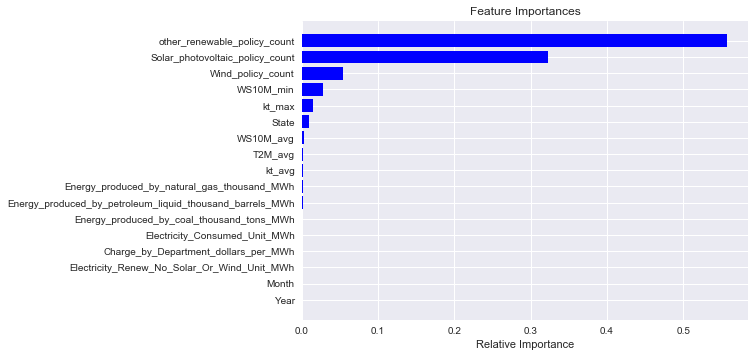

In [75]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

In [154]:
# writing the final dataset used in model
new_df.to_csv('model_wala_data.csv')